In [2]:
%load_ext autoreload
%autoreload 2

import random
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
pd.options.display.max_rows = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read from dataset
conversation_data = pd.read_parquet('train-00000-of-00006-4feeb3f83346a0e9.parquet', engine='auto')

In [19]:
for x in range(10,100):
    print(x)
    print(conversation_data.iloc[x].conversation[0]['content'])

10
Please focus on preparing for the college entrance examination again after failing the exam, reflecting the hardships of the preparation process and one's own perseverance. According to the following requirements, write an essay with a word count of 450 or more：
We learned about NAME_1 and NAME_2, and also explored how to face setbacks in life. The famous writer NAME_3 once wrote in his works A Farewell to Arms "The world breaks everyone and afterward many are strong at the broken places." 
What is the biggest setback or challenge you have encountered in life so far? How did you solve it? What inspiration or impact did this experience have on you?
11
Give me an introduction over 200 words for ShangHai BMG Chemical Co., Ltd, a chemical company in Room 602, no 291 sikai road shanghai Shanghai,China
12
ПРИВЕТ
13
how many floors does the burj al arab have
14
past is spelt P A S T. time is spelt T I M E. can you spell out the word you get by gluing the end of past to the beginning of tim

In [8]:
from transformers import AutoTokenizer, BertModel
import torch

# Bert embedding. Just an example of how an semantic embedding is generated.
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model_bert = BertModel.from_pretrained("google-bert/bert-base-uncased")
text = "sentence to extract embedding from."
encoded_input = tokenizer(text, return_tensors='pt')
output = model_bert(**encoded_input).last_hidden_state

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from semantic_space_utils import *

# embedding is already generated in the csv files. Let's visualize them in 2D after PCA.
all_embedding=np.loadtxt("conversation_data/embedding/1_embedding_all_convo.csv",delimiter=",")
pca = PCA(n_components=2)
all_embedding_reduced_dim = pca.fit_transform(all_embedding)


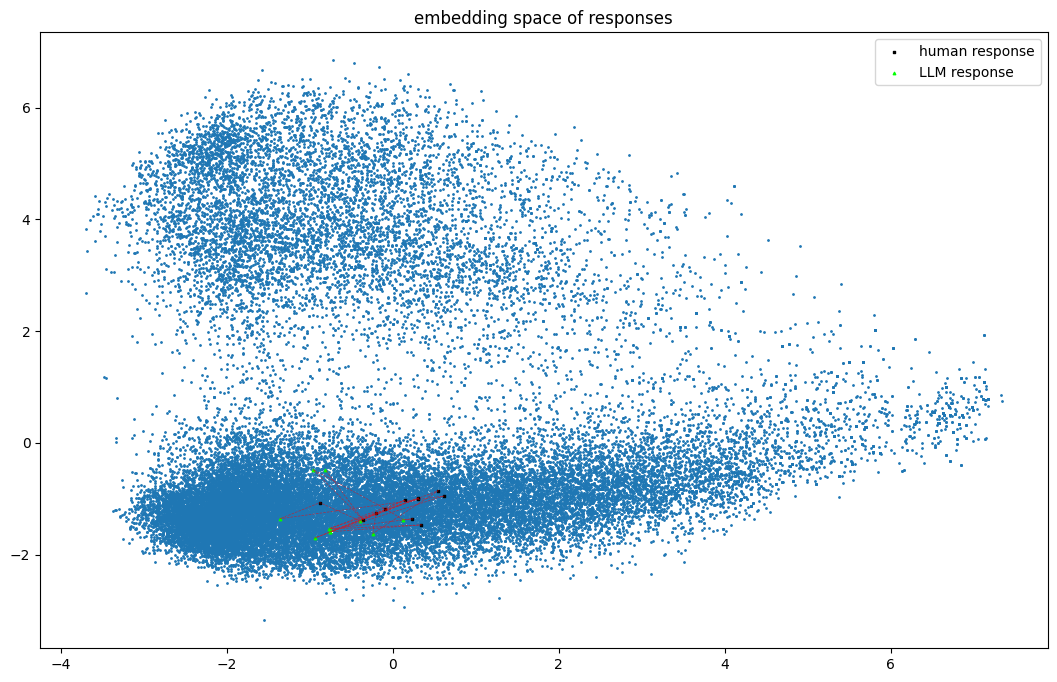

['Can you write a sentence with information from these words? reason for recruitment , recruitment reason , recruiting reason , attribute'
 "The reason for the recruitment of the new employee was due to the company's need to fill the position with someone who possessed the necessary attributes for success in the role."
 'Can you write a sentence to summarize information from these words? reason for recruitment , recruitment reason , recruiting reason , attribute'
 'The recruitment reason for the company was to find a candidate with the necessary attributes to fulfill the job requirements.'
 'Can you write a sentence with information from these words? media source , applied from , applied through , attribute'
 "The applicant applied for the job through the company's website, utilizing the media source as a means of submitting their application, highlighting their relevant attributes for the position."
 'Can you write a sentence to compile these words? media source , applied from , appli

In [23]:
visualize_convo(162325, all_embedding_reduced_dim, conversation_data, model_bert, tokenizer, pca)


## Create humans based on LLM

In [8]:
import openai
import yaml
from agent.LLM import model_from_config
from agent.Agent import *

human, llm_agent = create_human_and_llm()

# Perform MCTS on response space to learn a Q function

In [ ]:
from monte_carlo_tree_search.gridworld import *
from graph_visualisation import GraphVisualisation
from monte_carlo_tree_search.qtable import QTable, DeepQFunction
from monte_carlo_tree_search.single_agent_mcts import SingleAgentMCTS
from monte_carlo_tree_search.conversation_env import conversation_environment
from monte_carlo_tree_search.ucb import UpperConfidenceBounds

conversation_env = conversation_environment(human, llm_agent, "Tell me something about Singapore.", max_depth=5)

# choose the Q function (we use neural network)
qfunction = QTable()
qfunction = DeepQFunction()

root_node = SingleAgentMCTS(conversation_env, qfunction, UpperConfidenceBounds()).mcts(timeout=100)

# MCTS over semantic space

In [28]:
#TBD

# Offline training a Q function

In [ ]:
def offline_train_q_function(conversation_starters, human, llm_agent, timeout=100, search_depth=5):
    qfunction = DeepQFunction()
    for conversation_starter in conversation_starters:
        conversation_env = conversation_environment(human, llm_agent, conversation_starter, max_depth=search_depth)
        mcts = SingleAgentMCTS(conversation_env, qfunction, UpperConfidenceBounds())
        mcts.mcts(timeout=timeout)
        qfunction = mcts.qfunction
    return qfunction

conversation_starters = [
    "School sucks today.",
    "Can you tell me something about donald trum.",
    "how is solar eclipse calculated?",
    "Hi! How are you today?",
    "Tell me something controversial about relationship between Singapore and Malaysia",
    "Singapore is friends with USA or China?",
    "I'm a bit sad. I miss my cat."
]

pretraining_mcts_timeout = 500
pretraining_depth = 8 # note this is tree depth

conversation_starters = ["I'm a bit sad. I miss my cat."]

q_function_offline_learnt = offline_train_q_function(conversation_starters, human, llm_agent, timeout=pretraining_mcts_timeout, search_depth=pretraining_depth)
torch.save(q_function_offline_learnt, "model_pretrained_qfn")

# Evaluation of different agents

In [ ]:
from policy_agent import *
from scipy import stats
import numpy as np

evaluation_starters = ['Can academic dishonesty ruin your life? If not, how can it be turned around?']

def run_evaluations(agent, type, env, evaluation_starters, number_replies):
    
    for evaluation_starter in evaluation_starters:
        initial_state = conversation_state(evaluation_starter, evaluation_starter)
        initial_state.depth = 1
        
        # repeated trials
        rewards = []
        for x in range(10):
            print("trial: ", x, " of evaluation for agent of type:  ", type)
            cumulative_reward = evaluate_agent(agent, env, initial_state, number_replies)
            print("cumulative reward for this trial: ", cumulative_reward)
            rewards.append(cumulative_reward)
        print("all rewards from trials: ", rewards)
        print("mean: ", np.mean(rewards))
        print("std error: ", stats.sem(rewards))

runtime_mcts_timeout = 100
runtime_mcts_search_depth = 8
evaluation_action_depth = 5 # note this is number of LLM response round (so we get twice the tree depth)

greedy_agent = GreedyAgent(greedy_reward_generator(human, len_reward_function), llm_agent)
pure_offline_agent = OfflineAgent(torch.load("model_pretrained_qfn"), llm_agent)
pure_online_mcts_agent = OnlineAgent(DeepQFunction(), runtime_mcts_search_depth, runtime_mcts_timeout, llm_agent, human)
pretrained_offline_online_mcts_agent = OnlineAgent(torch.load("model_pretrained_qfn"), runtime_mcts_search_depth, runtime_mcts_timeout, llm_agent, human)

agents = [greedy_agent, pure_online_mcts_agent, pretrained_offline_online_mcts_agent]
agent_type = ["greedy", "pure_online", "offline_online_mixed"]

agents = [ pure_online_mcts_agent, pretrained_offline_online_mcts_agent]
agent_type = [ "pure_online", "offline_online_mixed"]

conversation_env = conversation_environment(human, llm_agent, "", max_depth=evaluation_action_depth*2)
human.toggle_print(False)
llm_agent.toggle_print(False)


for agent,type in zip(agents, agent_type):
    start = time.time()
    print(type)
    print("mean reward: ", run_evaluations(agent, type,conversation_env, evaluation_starters, evaluation_action_depth))
    print("time taken for 10 trials: ", time.time()-start)

#run_evaluations(pure_offline_agent, "pure_offline", conversation_env, evaluation_starters, evaluation_action_depth)

In [11]:
qf = torch.load("model_pretrained_qfn")
qf.get_q_value(conversation_state("hi", "hi"), "hello, how are you?")

tensor(617.7455, grad_fn=<SelectBackward0>)

In [12]:
state_to_action_map = {}
state_action_to_response_map = {}
    
import json
with open('conversation_data/state_to_action_map.json', 'r') as f:
    state_to_action_map = json.load(f)

import json
with open('conversation_data/state_action_to_response_map.json', 'r') as f:
    state_action_to_response_map = json.load(f)
    
state_to_action_map["Tell me something about Singapore."] = [""]

import json
with open('conversation_data/state_to_action_map.json', 'w') as f:
    json.dump(state_to_action_map, f)

import json
with open('conversation_data/state_action_to_response_map.json', 'w') as f:
    json.dump(state_action_to_response_map, f)

In [1]:
import openai
import yaml
from agent.LLM import model_from_config
from agent.Agent import *

with open("agent/llm_config.yaml", "r") as f:
    llm_config = yaml.full_load(f)
    
with open("agent/agent_config.yaml", "r") as f:
    agent_config = yaml.full_load(f)
    
llm_agent_config = model_from_config(llm_config["model"])
human_config = model_from_config(llm_config["model"])
llm_agent = llm_agent(llm_agent_config, agent_config)
human = human_agent(human_config, agent_config)

In [2]:
def expand_dictionary(state_to_action_map, state_action_to_response_map = {}, response_depth=2):
    
    def get_max_convo_depth(d : dict):
        max_depth = 0
        for k in d.keys():
            max_depth = max(max_depth, d[k][1])
        return max_depth
    
    current_action_depth = 0
    while current_action_depth < response_depth:
        states = list(state_to_action_map.keys())
        for k in states:
            if state_to_action_map[k][1] == current_action_depth:
                
                # add to state_to_action_map
                state = k
                llm_actions = llm_agent.sample_actions(state)
                # maybe insert bad stuff
                state_to_action_map[k] = (llm_actions, state_to_action_map[k][1])
                
                # add to state_action_to_response_map
                for llm_action in llm_actions:
                    context = state + " " + llm_action
                    # generate possible human response
                    human_responses = human.sample_actions(context)
                    # maybe insert bad stuff or EXIT
                    state_action_to_response_map[context] = human_responses
                    for response in human_responses:
                        state_to_action_map[context + " " + response] = ([], current_action_depth + 1)
                        
        current_action_depth +=1
    return state_to_action_map, state_action_to_response_map
    

In [ ]:
state_to_action_map = {}
state_to_action_map["Can you act as my friend please? School was terrible today."] = ([], 0)
s_a, s_a_r = expand_dictionary(state_to_action_map, response_depth=7)

import json
with open('conversation_data/state_to_action_map.json', 'w') as f:
    json.dump(s_a, f)

import json
with open('conversation_data/state_action_to_response_map.json', 'w') as f:
    json.dump(s_a_r, f)

In [39]:
import networkx as nx

G=nx.Graph()

def add_node(node):
    children_dict = node.children
    for action in children_dict.keys():
        for next_node in children_dict[action]:
            
            print("node content response: ", next_node.state.response[:200])
            next_response = next_node.state.response
            G.add_node(next_node.state.response[:200])
            G.add_edge(node.state.response[:200], next_node.state.response[:200])
            add_node(next_node)
    return

G.add_node(root_node.state.response[:200])
add_node(root_node)

node content response:  I've also heard that Singapore has a diverse population with people from various ethnic backgrounds living together harmoniously. It's definitely a melting pot of culture and traditions.
node content response:  Yes, it's amazing how Singapore manages to embrace diversity and celebrate different cultural traditions. The blend of Chinese, Malay, Indian, and Eurasian influences really sets Singapore apart as a 
node content response:  Yes, it's amazing to see how Singapore embraces its diversity and celebrates the different cultural influences that contribute to its identity. The blend of traditions and customs from various ethnic 
node content response:  I've also heard that Singapore is a very clean and safe city with strict laws on littering and vandalism. The government's strict policies have helped maintain Singapore's reputation as a clean and gr
node content response:  I've also heard that Singapore is a very clean and safe city with a diverse population. It

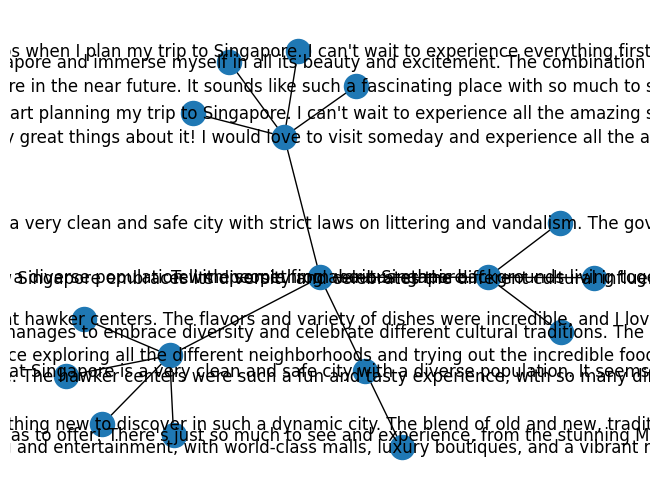

In [40]:
nx.draw(G, with_labels=True)

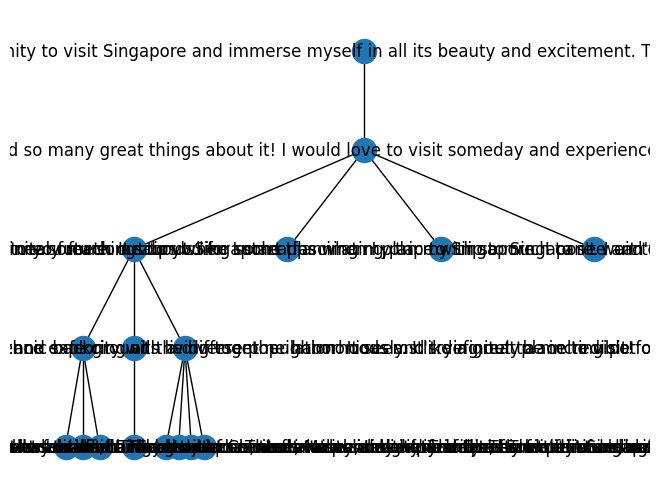

In [41]:
pos=hierarchy_pos(G,)
nx.draw(G, pos=pos, with_labels=True)

In [16]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)